In [1]:
import pandas as pd
import os

In [ ]:
#dataset directory
data_dir = 'dataset/'
# File paths to get all the data
fake_real_fake_path = os.path.join(data_dir, 'Fake.csv')
fake_real_true_path = os.path.join(data_dir, 'True.csv')
welfake_path = os.path.join(data_dir, 'WELFake_Dataset.csv')

In [ ]:
#load the dataset
df_fake_real_fake = pd.read_csv(fake_real_fake_path)
df_fake_real_true = pd.read_csv(fake_real_true_path)

#create labels to differinate between true or false
df_fake_real_fake['label'] = 0 
df_fake_real_true['label'] = 1 

#combine the fake and true into one pd
df_fake_real = pd.concat([df_fake_real_fake, df_fake_real_true], ignore_index=True)

print(f"Loaded Fake and Real News Dataset: {df_fake_real.shape[0]} samples")

#load the other dataset no labels needed since its already part of the data
df_welfake = pd.read_csv(welfake_path)
print(f"Loaded WELFake Dataset: {df_welfake.shape[0]} samples")

Loading datasets...
Loaded Fake and Real News Dataset: 44898 samples
Loaded WELFake Dataset: 72134 samples


In [ ]:
#print out the column names in the dataset
print("\nColumns in Fake and Real News Dataset:", df_fake_real.columns)
print("Columns in WELFake Dataset:", df_welfake.columns)

#find the total number of fake and real news in each dataset
print("\nCounts in Fake and Real News Dataset:\n", df_fake_real['label'].value_counts())
print("Counts in WELFake Dataset :\n", df_welfake['label'].value_counts())


Inspecting and standardizing columns and labels...

Columns in Fake and Real News Dataset: Index(['title', 'text', 'subject', 'date', 'label'], dtype='object')
Columns in WELFake Dataset: Index(['Serial number', 'title', 'text', 'label'], dtype='object')

Labels in Fake and Real News Dataset (should be 0 or 1):
 label
0    23481
1    21417
Name: count, dtype: int64
Labels in WELFake Dataset (should be 0 or 1):
 label
1    37106
0    35028
Name: count, dtype: int64


In [ ]:
#combine dataset

#select the 3 main column needed
cols_to_use = ['title', 'text', 'label']
df_fake_real_subset = df_fake_real[cols_to_use]
df_welfake_subset = df_welfake[cols_to_use]

#combine the 2 into 1 pd
df_combined = pd.concat([df_fake_real_subset, df_welfake_subset], ignore_index=True)
print(f"Combined dataset size: {df_combined.shape[0]} samples")


Combining datasets...
Combined dataset initial size: 117032 samples


In [ ]:
#delete duplicates if there are the exact same text
initial_samples = df_combined.shape[0]
df_combined.drop_duplicates(subset=['text'], keep='first', inplace=True)
samples_after_deduplication = df_combined.shape[0]

#samples removed in duplication
print(f"Samples removed after duplication: {initial_samples - samples_after_deduplication} samples")
#new sample size
print(f"New size after removing duplicates: {samples_after_deduplication} samples")



Handling duplicates based on text content...
Samples removed due to duplication: 34800
Combined dataset size after de-duplication: 82232 samples


In [ ]:
#missing values check
print(f"Missing values:")
print(df_combined.isnull().sum())

#remove samples with missing text as it what we are mainly comparing
initial_samples_after_dedup = df_combined.shape[0]
df_combined.dropna(subset=['text'], inplace=True)
samples_after_dropna = df_combined.shape[0]

#samples removed during missing processing
if initial_samples_after_dedup - samples_after_dropna > 0:
    print(f"Samples removed: {initial_samples_after_dedup - samples_after_dropna}")
    print(f"New size after removing missing texts: {samples_after_dropna} samples")
else:
     print("No samples removed.")


Checking for missing values...
title    518
text       1
label      0
dtype: int64
Samples removed due to missing text: 1
Combined dataset size after dropping NaNs: 82231 samples


In [ ]:
#data summary
print("\nFinal Combined Dataset Summary")
print(f"Total samples: {df_combined.shape[0]}")
#distrubtion
print("\nTrue and Fake Distrubtion:")
print(df_combined['label'].value_counts())
#sample summary
print("\nSample summary:")
print(df_combined.head())

#new index after dropping rows
df_combined.reset_index(drop=True, inplace=True)


--- Final Combined Dataset Summary ---
Total samples: 82231

Label distribution:
label
0    47633
1    34598
Name: count, dtype: int64

Sample data:
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text  label  
0  Donald Trump just couldn t wish all Americans ...      0  
1  House Intelligence Committee Chairman Devin Nu...      0  
2  On Friday, it was revealed that former Milwauk...      0  
3  On Christmas day, Donald Trump announced that ...      0  
4  Pope Francis used his annual Christmas Day mes...      0  


In [13]:
import spacy
import re

In [ ]:
#pretrained nlp model with english word
nlp = spacy.load("en_core_web_sm")
#lets us load our words
custom_stop_words = set()

In [ ]:
#cleaning text input
def preprocess_text(text):
    #empty for non-string inputs
    if not isinstance(text, str):
        return ""

    #lowercase everything and remove whitespaces
    text = text.lower().strip()

    #remove any urls 
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    #remove any character that is not a lowercase or spae
    text = re.sub(r'[^a-z\s]', '', text)

    #use spacy to tokenize the text
    doc = nlp(text) 

    cleaned_tokens = []
    for token in doc:
        #ignore punctation, whitespace, stopwords, and non-alpha
        if not token.is_punct and not token.is_space and not token.is_stop and token.is_alpha:
             #append lemmatized form of token
             cleaned_tokens.append(token.lemma_)
    return cleaned_tokens 
    
#count number of sentences
def count_sentences(text):
    #return 0 if input is non-empty string
    if not isinstance(text, str) or not text.strip():
        return 0
    #return 0 if nlp pipeline is not loading
    if nlp_sent is None: 
        return 0
    #process text and count sentences
    doc = nlp_sent(text)
    return len(list(doc.sents))

#calculate avg tokens per sentence
def avg_sentence_length_processed(processed_tokens, sentence_count):
    #edgecase against division by zero or missing tokens
    if sentence_count is None or sentence_count == 0 or not processed_tokens:
        return 0.0
    total_tokens = len(processed_tokens)
    return total_tokens / sentence_count

#calculate proportion of uppercase
def uppercase_char_proportion(text):
    #invalid or empty input
    if not isinstance(text, str) or not text.strip():
         return 0.0
    #find all alpha characters
    alpha_chars = re.findall(r'[a-zA-Z]', text)
    if not alpha_chars: return 0.0
    #count uppercase and divide by total alpha characters
    upper_count = sum(1 for char in alpha_chars if char.isupper())
    return upper_count / len(alpha_chars)

#calculate the number of a certian punctation in text
def count_punctuation(text, punct_char='!'):
    #invalid empty input
    if not isinstance(text, str):
        return 0
    return text.count(punct_char)

In [ ]:

from tqdm.auto import tqdm
from pandarallel import pandarallel 

#calculate number of cores and set workers for pandarallel
num_cores = os.cpu_count()
workers_to_use = max(1, num_cores - 2) #at least 1 core
pandarallel.initialize(progress_bar=True, nb_workers=workers_to_use)
print(f"Initializing pandarallel with {workers_to_use} workers")

#apply the preprocessing function to text and title columns parallely
df_combined['processed_text'] = df_combined['text'].parallel_apply(preprocess_text)
df_combined['processed_title'] = df_combined['title'].parallel_apply(preprocess_text)


#count sentence in each text
df_combined['sentence_count'] = df_combined['text'].parallel_apply(count_sentences)
   
#calculate average sentence length
df_combined['avg_sentence_length'] = df_combined.apply(
             lambda row: avg_sentence_length_processed(row.get('processed_text', []), row.get('sentence_count', 0)),
             axis=1
        )

#uppercase characters
df_combined['uppercase_char_prop'] = df_combined['text'].parallel_apply(uppercase_char_proportion)
#exclamation count
df_combined['exclamation_count'] = df_combined['text'].parallel_apply(lambda x: count_punctuation(x, '!'))
#question count
df_combined['question_count'] = df_combined['text'].parallel_apply(lambda x: count_punctuation(x, '?'))
#quotes count
df_combined['quotes_count'] = df_combined['text'].parallel_apply(lambda x: count_punctuation(x, '"') + count_punctuation(x, "'"))

#sample of the processed data
print("\nProcessed data with new features:")
print(df_combined.head())

#path for saving data
data_dir = 'dataset/'
processed_data_path = os.path.join(data_dir, 'combined_processed_articles.pkl')

#save all the data
print(f"\nSaving processed data to {processed_data_path}...")
df_combined.to_pickle(processed_data_path)
print("Succesfully saved data")

INFO: Pandarallel will run on 9 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Initializing pandarallel with 9 workers...

Applying core text preprocessing (tokenization, lemma) (with parallel progress)...



Calculating structural and stylistic features (with parallel progress)...


Calculating average sentence length (single-threaded)...



Preprocessing and all feature calculations complete.

Sample original and processed data with new features:
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text  label  \
0  Donald Trump just couldn t wish all Americans ...      0   
1  House Intelligence Committee Chairman Devin Nu...      0   
2  On Friday, it was revealed that former Milwauk...      0   
3  On Christmas day, Donald Trump announced that ...      0   
4  Pope Francis used his annual Christmas Day mes...      0   

                                      processed_text  \
0  [donald, trump, couldn, t, wish, americans, ha...   
1  [house, intelligence, committee, chairman, dev...   
2  [fri

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk import ngrams

#data path
data_dir = 'dataset/'
processed_data_path = os.path.join(data_dir, 'combined_processed_articles.pkl')

#load the data
print(f"Loading processed data from {processed_data_path}")
df_combined = pd.read_pickle(processed_data_path)
print("Succesfully loaded data!")
print(f"Shape: {df_combined.shape}")
print("Columns:", df_combined.columns)

Loading processed data from dataset/combined_processed_articles.pkl...
Processed data loaded successfully.
Loaded DataFrame shape: (82231, 12)
Columns: Index(['title', 'text', 'label', 'processed_text', 'processed_title',
       'processed_text_length', 'sentence_count', 'avg_sentence_length',
       'uppercase_char_prop', 'exclamation_count', 'question_count',
       'quotes_count'],
      dtype='object')



Starting EDA on processed data and derived features...


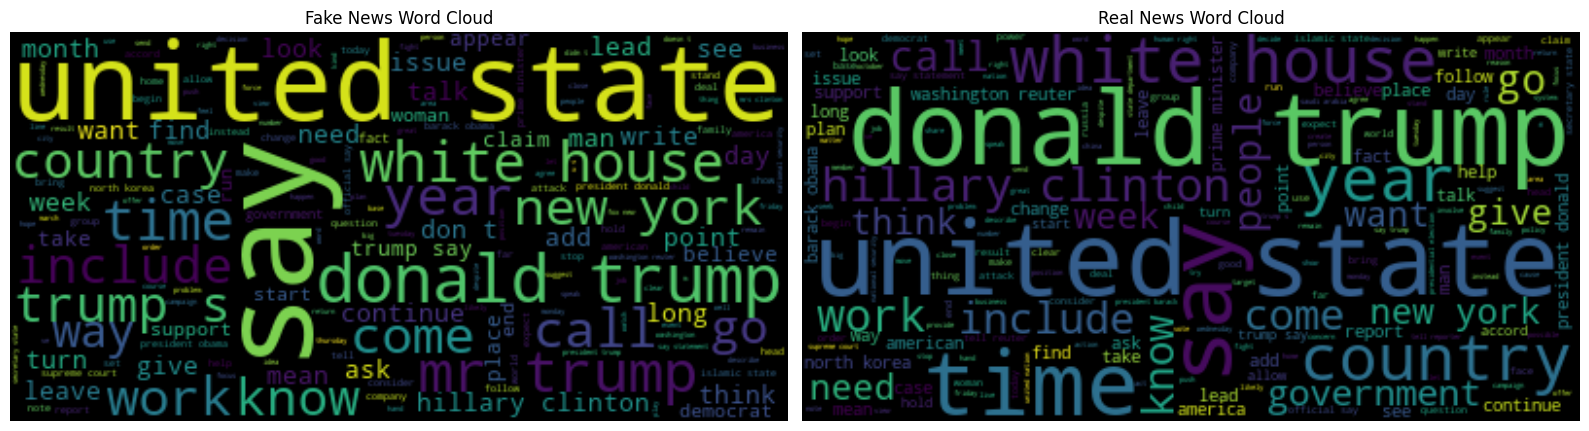

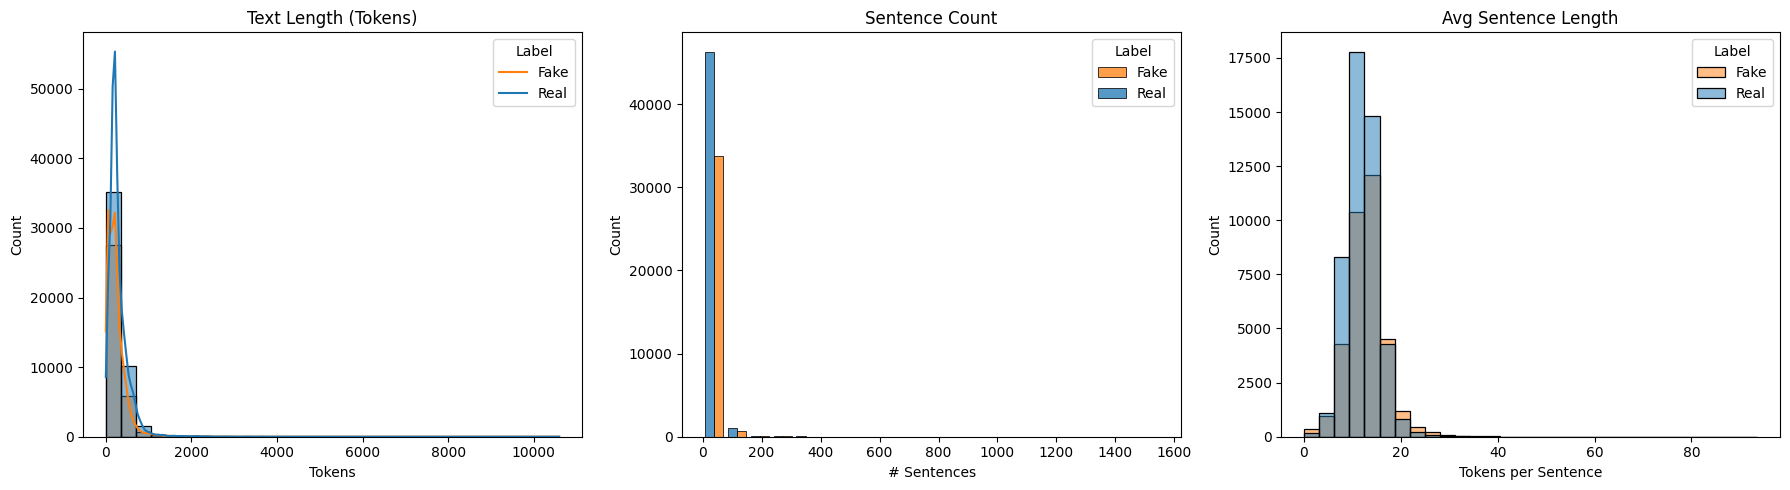

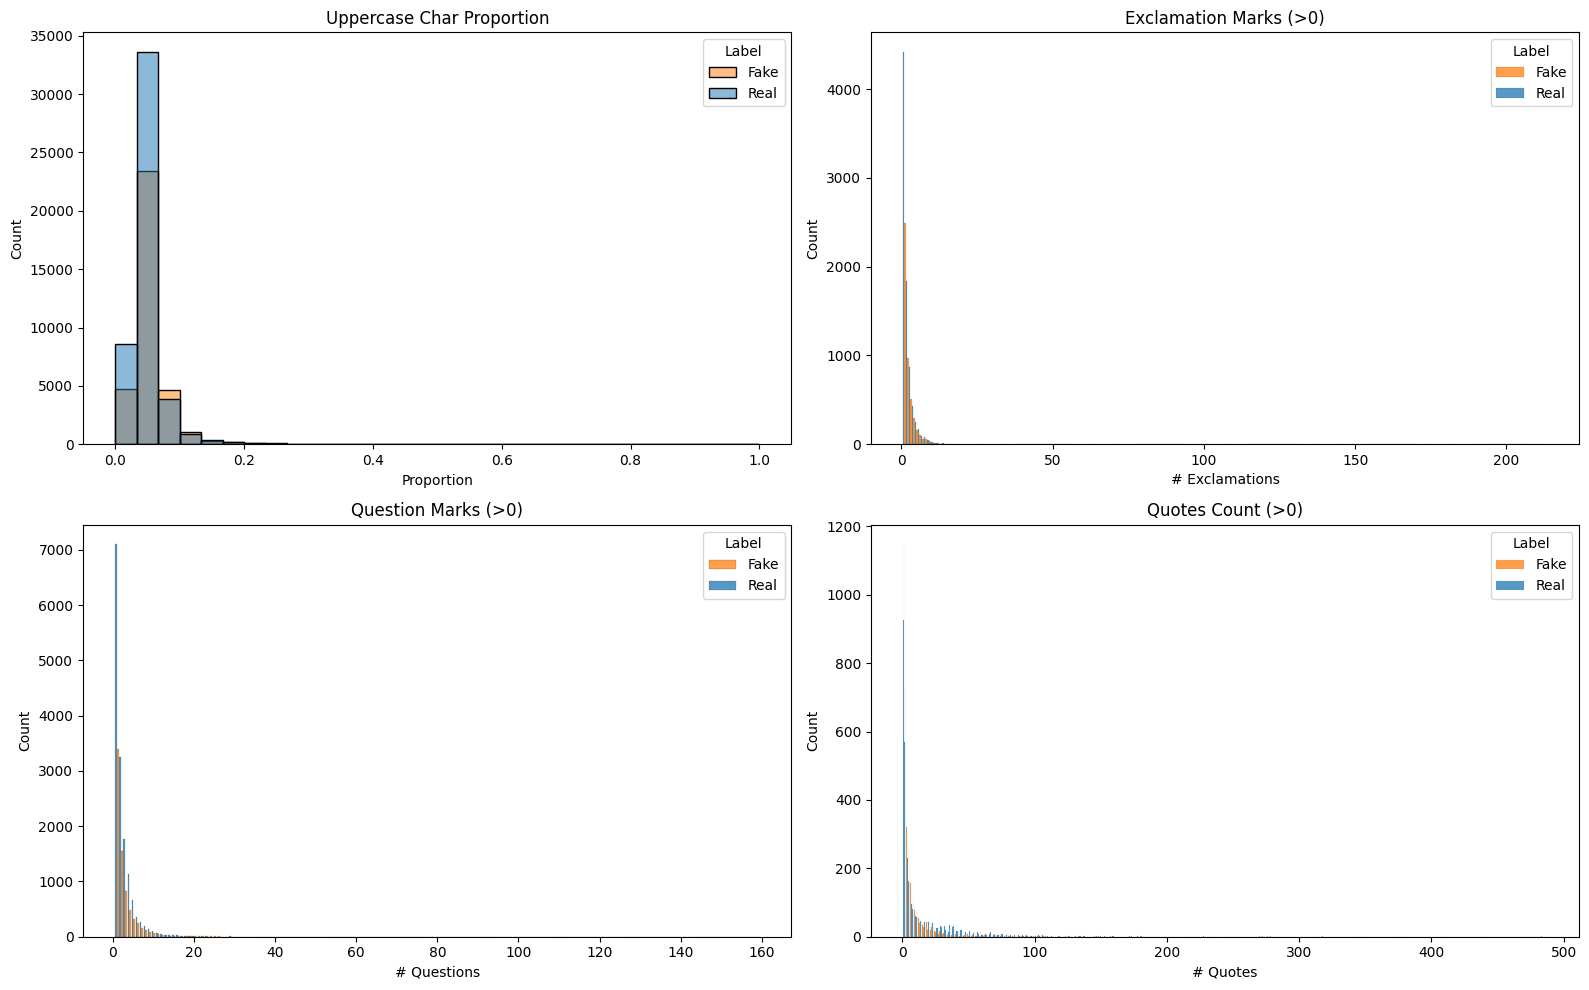

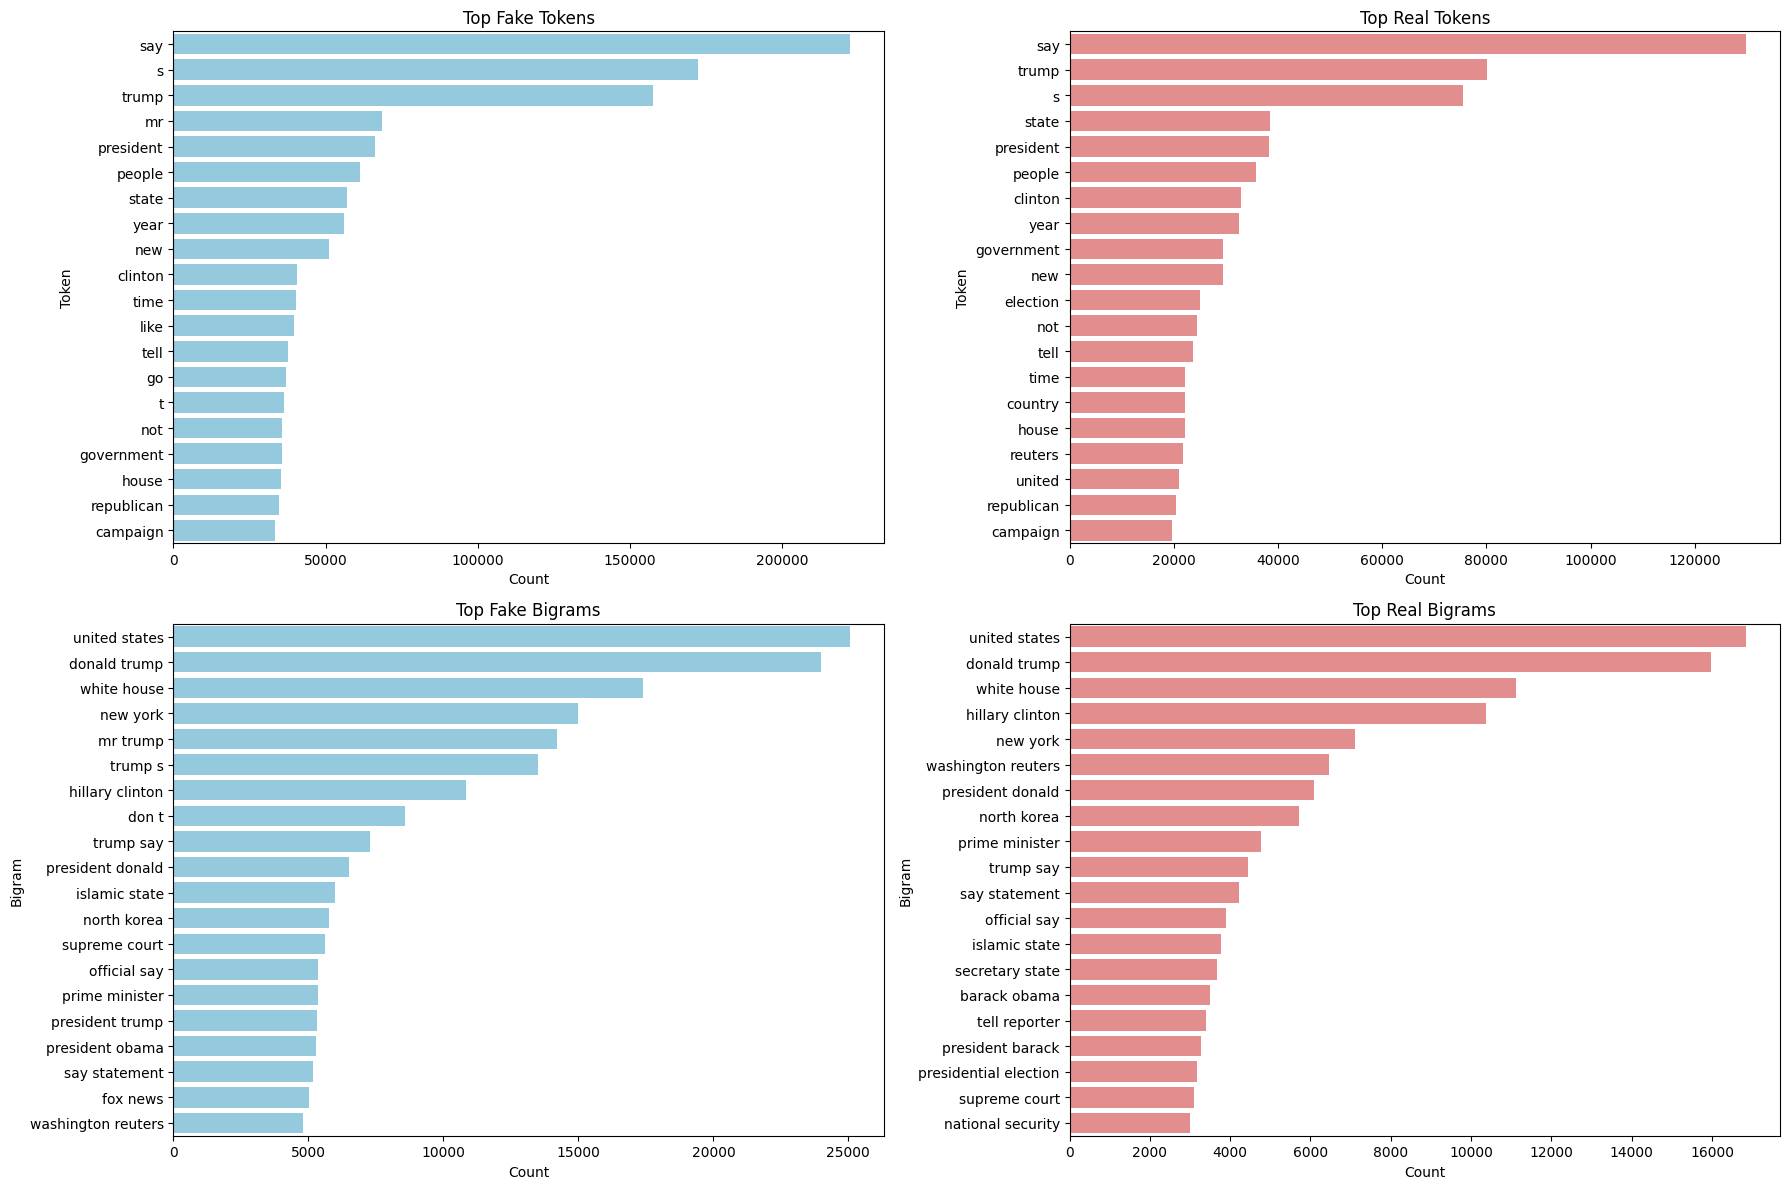


EDA complete. Analyze the outputs and plots for insights!


In [ ]:

print("\nEDA:")

#check all req columns
required_cols = [
    'label', 'processed_text', 'processed_title',
    'sentence_count', 'avg_sentence_length',
    'uppercase_char_prop', 'exclamation_count',
    'question_count', 'quotes_count',
    'processed_text_length'
]
#make sure all column names are present
for col in required_cols:
    if col not in df_combined.columns:
        print(f"⚠️ Missing column: {col}")

#make one single token list with all processed text
all_tokens = [
    token
    for doc in df_combined['processed_text'].dropna()
    for token in doc
]
token_counts = Counter(all_tokens)

#seperate tokens by label fake and real news
fake_tokens = [
    token
    for doc in df_combined[df_combined['label'] == 0]['processed_text'].dropna()
    for token in doc
]
real_tokens = [
    token
    for doc in df_combined[df_combined['label'] == 1]['processed_text'].dropna()
    for token in doc
]
fake_token_counts = Counter(fake_tokens)
real_token_counts = Counter(real_tokens)

#generate n-grams from given token list
def get_ngrams(tokens, n):
    return list(ngrams(tokens, n)) if len(tokens) >= n else []

#build bigrams for fake and real news
fake_bigrams = [
    bg
    for doc in df_combined[df_combined['label']==0]['processed_text'].dropna()
    for bg in get_ngrams(doc, 2)
]
real_bigrams = [
    bg
    for doc in df_combined[df_combined['label']==1]['processed_text'].dropna()
    for bg in get_ngrams(doc, 2)
]

#put tokens back into strings for word cloud
fake_str = " ".join(all_tokens for all_tokens in fake_tokens)
real_str = " ".join(all_tokens for all_tokens in real_tokens)

plt.figure(figsize=(16,6))
#create fake news cloud
plt.subplot(1,2,1)
WordCloud(width=800, height=400, background_color='white', max_words=100).generate(fake_str)
plt.imshow(WordCloud().generate(fake_str), interpolation='bilinear')
plt.axis('off'); plt.title('Fake News Word Cloud')

#create real news cloud
plt.subplot(1,2,2)
plt.imshow(WordCloud().generate(real_str), interpolation='bilinear')
plt.axis('off'); plt.title('Real News Word Cloud')
plt.tight_layout()
plt.show()


fig, axes = plt.subplots(1, 3, figsize=(18, 5))

#text length distrubtion fake or real bar graph
sns.histplot(
    df_combined, x='processed_text_length', hue='label',
    kde=True, multiple="layer", alpha=0.5,
    bins=30, ax=axes[0]
)
axes[0].set(
    title='Text Length',
    xlabel='Tokens', ylabel='Count'
)
axes[0].legend(title='Label', labels=['Fake','Real'])

#sentence count distrubtion fake or real bar graph
sns.histplot(
    df_combined, x='sentence_count', hue='label',
    discrete=False, multiple="dodge", shrink=0.8,
    bins=20, ax=axes[1]
)
axes[1].set(
    title='Sentence Count',
    xlabel='# Sentences', ylabel='Count'
)
axes[1].legend(title='Label', labels=['Fake','Real'])

#average sentence length distrubtion fake or real bar graph
sns.histplot(
    df_combined, x='avg_sentence_length', hue='label',
    kde=False, multiple="layer", alpha=0.5,
    bins=30, ax=axes[2]
)
axes[2].set(
    title='Avg Sentence Length',
    xlabel='Tokens per Sentence', ylabel='Count'
)
axes[2].legend(title='Label', labels=['Fake','Real'])

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

#uppercase character distrubtion fake or real bar graph
sns.histplot(
    df_combined, x='uppercase_char_prop', hue='label',
    multiple="layer", alpha=0.5, bins=30, ax=axes[0]
)
axes[0].set(
    title='Uppercase Char Proportion',
    xlabel='Proportion', ylabel='Count'
)
axes[0].legend(title='Label', labels=['Fake','Real'])

#exclamation mark distrubtion fake or real bar graph
ex = df_combined[df_combined['exclamation_count'] > 0]
sns.histplot(
    ex, x='exclamation_count', hue='label',
    discrete=True, multiple="dodge", shrink=0.8,
    ax=axes[1]
)
axes[1].set(
    title='Exclamation Marks',
    xlabel='# Exclamations', ylabel='Count'
)
axes[1].legend(title='Label', labels=['Fake','Real'])

#question mark distrubtion fake or real bar graph
q = df_combined[df_combined['question_count'] > 0]
sns.histplot(
    q, x='question_count', hue='label',
    discrete=True, multiple="dodge", shrink=0.8,
    ax=axes[2]
)
axes[2].set(
    title='Question Marks',
    xlabel='# Questions', ylabel='Count'
)
axes[2].legend(title='Label', labels=['Fake','Real'])

#quotes distrubtion fake or real bar graph
qt = df_combined[df_combined['quotes_count'] > 0]
sns.histplot(
    qt, x='quotes_count', hue='label',
    discrete=True, multiple="dodge", shrink=0.8,
    ax=axes[3]
)
axes[3].set(
    title='Quotes Count (>0)',
    xlabel='# Quotes', ylabel='Count'
)
axes[3].legend(title='Label', labels=['Fake','Real'])

plt.tight_layout()
plt.show()


#find top n tokens for fake and real
n_top = 20
top_fake = pd.DataFrame(fake_token_counts.most_common(n_top), columns=['token','count'])
top_real = pd.DataFrame(real_token_counts.most_common(n_top), columns=['token','count'])

# convert bigrams to strings
fb = pd.DataFrame(Counter(fake_bigrams).most_common(n_top), columns=['bigram','count'])
fb['bigram'] = fb['bigram'].apply(lambda x: ' '.join(x))
rb = pd.DataFrame(Counter(real_bigrams).most_common(n_top), columns=['bigram','count'])
rb['bigram'] = rb['bigram'].apply(lambda x: ' '.join(x))

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
ax1, ax2, ax3, ax4 = axes.flatten()

#plot top fake token
sns.barplot(x='count', y='token', data=top_fake, ax=ax1, color='skyblue')
ax1.set(title='Top Fake Tokens', xlabel='Count', ylabel='Token')

#plot top real tokens
sns.barplot(x='count', y='token', data=top_real, ax=ax2, color='lightcoral')
ax2.set(title='Top Real Tokens', xlabel='Count', ylabel='Token')

#plot top fake bigrams
sns.barplot(x='count', y='bigram', data=fb, ax=ax3, color='skyblue')
ax3.set(title='Top Fake Bigrams', xlabel='Count', ylabel='Bigram')

#plot top real bigrams
sns.barplot(x='count', y='bigram', data=rb, ax=ax4, color='lightcoral')
ax4.set(title='Top Real Bigrams', xlabel='Count', ylabel='Bigram')

plt.tight_layout()
plt.show()

print("EDA Done!")

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack # For combining sparse and dense features
from tqdm.auto import tqdm
from pandarallel import pandarallel

In [ ]:
#feature engineering
print(df_combined.head())

#conver tokens to single strings for TF-IDF vectorization
if 'processed_text_string' not in df_combined.columns:
    df_combined['processed_text_string'] = df_combined['processed_text'].apply(lambda tokens: ' '.join(tokens))
if 'processed_title_string' not in df_combined.columns:
     df_combined['processed_title_string'] = df_combined['processed_title'].apply(lambda tokens: ' '.join(tokens))


#combine title and text
df_combined['processed_combined_string'] = df_combined['processed_title_string'] + " " + df_combined['processed_text_string']

#start TF-IDF vectorizer with max features of 20,000 while ignoring words that appear in less than 5% or more than 95%
tfidf_vectorizer = TfidfVectorizer(max_features=20000, 
                                   min_df=5,
                                   max_df=0.95)

#fit vector and make a df out of it
X_tfidf = tfidf_vectorizer.fit_transform(df_combined['processed_combined_string'].dropna()) 

#df shape
print("TF-IDF Feature Matrix Shape:", X_tfidf.shape)

#other engineering numerical features
numerical_features_cols = ['sentence_count', 'avg_sentence_length',
                           'uppercase_char_prop', 'exclamation_count',
                           'question_count', 'quotes_count']

#make sure all columns exists and fill NaNs with 0s
numerical_features = df_combined[numerical_features_cols].fillna(0)

print("Numerical Features Shape:", numerical_features.shape)

#combine both numerical and vector features into hstack
X = hstack([X_tfidf, numerical_features])

print("Final Feature Matrix Shape:", X.shape)

#create label vector 
y = df_combined['label'].values

print("Label Vector Shape:", y.shape)

print("Feature Engineering Done!")


Starting Feature Engineering (TF-IDF)...
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text  label  \
0  Donald Trump just couldn t wish all Americans ...      0   
1  House Intelligence Committee Chairman Devin Nu...      0   
2  On Friday, it was revealed that former Milwauk...      0   
3  On Christmas day, Donald Trump announced that ...      0   
4  Pope Francis used his annual Christmas Day mes...      0   

                                      processed_text  \
0  [donald, trump, couldn, t, wish, americans, ha...   
1  [house, intelligence, committee, chairman, dev...   
2  [friday, reveal, milwaukee, sheriff, david, cl...   
3  [christmas, day

In [30]:
from sklearn.model_selection import train_test_split

In [ ]:
#split training/testing 80/20 
test_set_size = 0.2

#random seed to get same split every time
random_state = 42

#train and test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=test_set_size,
    random_state=random_state,
    stratify=y
)

print(f"Original data shape: {X.shape}")
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape : {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")

#ensure proportion of labels are same in training and testing
print("\nLabel distribution for original data:")
print(pd.Series(y).value_counts(normalize=True))
print("\nLabel distribution for training data:")
print(pd.Series(y_train).value_counts(normalize=True))
print("\nLabel distribution for testing data:")
print(pd.Series(y_test).value_counts(normalize=True))

print("Data Splitting Done!")


Splitting data into training and testing sets...
Original data shape: (82231, 20006)
Training data shape (X_train): (65784, 20006)
Testing data shape (X_test): (16447, 20006)
Training labels shape (y_train): (65784,)
Testing labels shape (y_test): (16447,)

Label distribution in original data:
0    0.579258
1    0.420742
Name: proportion, dtype: float64

Label distribution in training data:
0    0.579259
1    0.420741
Name: proportion, dtype: float64

Label distribution in testing data:
0    0.579255
1    0.420745
Name: proportion, dtype: float64

Data splitting complete. Data is ready for model training.


In [32]:
# Import the models from scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

In [ ]:

#train logsitic regression model
log_reg_model = LogisticRegression(random_state=42, max_iter=10000)
log_reg_model.fit(X_train, y_train)

print("Logistic Regression trained.")

#train multinomial naive bayes model
nb_model = MultinomialNB(alpha=1.0)
nb_model.fit(X_train, y_train)

print("Multinomial Naive Bayes trained.")



Starting Model Training...
Training Logistic Regression model...
Logistic Regression model trained.

Training Multinomial Naive Bayes model...
Multinomial Naive Bayes model trained.

Model training complete. Trained models are ready for evaluation.


In [34]:
# Import evaluation metrics from scikit-learn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [ ]:
print("Logistic Regression Model Evaluation:")

#prediction on test set
y_pred_log_reg = log_reg_model.predict(X_test)

# calculate metrics
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
precision_log_reg = precision_score(y_test, y_pred_log_reg, pos_label=0)
recall_log_reg = recall_score(y_test, y_pred_log_reg, pos_label=0)
f1_log_reg = f1_score(y_test, y_pred_log_reg, pos_label=0)
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg, labels=[0, 1])

#print the metrics
print(f"Accuracy: {accuracy_log_reg:.4f}")
print(f"Precision (Fake=0): {precision_log_reg:.4f}")
print(f"Recall (Fake=0): {recall_log_reg:.4f}")
print(f"F1-Score (Fake=0): {f1_log_reg:.4f}")

print("\nConfusion Matrix:")

print(conf_matrix_log_reg)

#overall logistic regression report
print("\nLogistic Regression Overall Metrics:")
print(classification_report(y_test, y_pred_log_reg, target_names=['Fake (0)', 'Real (1)']))

print("Multinomial Naive Bayes Model Evaluation:")
#predictions on the test set
y_pred_nb = nb_model.predict(X_test)

#calculate metrics
accuracy_nb = accuracy_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb, pos_label=0)
recall_nb = recall_score(y_test, y_pred_nb, pos_label=0)
f1_nb = f1_score(y_test, y_pred_nb, pos_label=0)
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb, labels=[0, 1])

#print metrics
print(f"Accuracy: {accuracy_nb:.4f}")
print(f"Precision (Fake=0): {precision_nb:.4f}")
print(f"Recall (Fake=0): {recall_nb:.4f}")
print(f"F1-Score (Fake=0): {f1_nb:.4f}")

print("\nConfusion Matrix:")
print(conf_matrix_nb)

#overall multinomial naive bayes metrics
print("\nMultinomial Naive Bayes Overall Metrics:")
print(classification_report(y_test, y_pred_nb, target_names=['Fake (0)', 'Real (1)']))

print("\nModel Evaluation Done!")


Starting Model Evaluation...

Evaluating Logistic Regression Model...
Logistic Regression - Accuracy: 0.6801
Logistic Regression - Precision (Fake=0): 0.7176
Logistic Regression - Recall (Fake=0): 0.7384
Logistic Regression - F1-Score (Fake=0): 0.7278

Logistic Regression - Confusion Matrix:
Actual Fake (0) | Predicted Fake (0)  Predicted Real (1)
Actual Real (1) | Predicted Fake (0)  Predicted Real (1)
[[7035 2492]
 [2769 4151]]

Logistic Regression - Classification Report:
              precision    recall  f1-score   support

    Fake (0)       0.72      0.74      0.73      9527
    Real (1)       0.62      0.60      0.61      6920

    accuracy                           0.68     16447
   macro avg       0.67      0.67      0.67     16447
weighted avg       0.68      0.68      0.68     16447


Evaluating Multinomial Naive Bayes Model...
Multinomial Naive Bayes - Accuracy: 0.6260
Multinomial Naive Bayes - Precision (Fake=0): 0.7142
Multinomial Naive Bayes - Recall (Fake=0): 0.5905
M

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline # Import Pipeline
from sklearn.metrics import make_scorer, f1_score # To use F1 as the scoring metric

In [ ]:

#define test set and random state
test_set_size = 0.2
random_state = 42

#get the needed text data title+body
text_data = df_combined['processed_combined_string'].dropna()
labels = df_combined['label'][df_combined['processed_combined_string'].notna()]

#split into training and testing while keeping labels
X_train_text, X_test_text, y_train, y_test = train_test_split(
    text_data,
    labels,
    test_size=test_set_size,
    random_state=random_state,
    stratify=labels
)

print(f"Training text data shape: {X_train_text.shape}")
print(f"Testing text data shape: {X_test_text.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")

print("\nText Data Splitting Done!")


Re-splitting text data and labels for pipeline input...
Training text data shape: (65784,)
Testing text data shape: (16447,)
Training labels shape (y_train): (65784,)
Testing labels shape (y_test): (16447,)

Text data splitting complete. Ready for pipeline and GridSearchCV.


In [ ]:
print("HyperParamater Tuning")

#pipeline for tuning
pipeline = Pipeline([
    # Step 1: 'tfidf' - vectorizer
    ('tfidf', TfidfVectorizer()),
    # Step 2: 'log_reg' - the moedl
    ('log_reg', LogisticRegression(random_state=42, max_iter=6000))
])


#define the paramters for the grid
param_grid_pipeline = {
    #tfidf paramters
    #vocab size
    'tfidf__max_features': [15000, 20000, 25000],
    #unigrams vs unigrams+bigrams
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    #ignore <5% or <10% terms in docs
    'tfidf__min_df': [5, 10],
    #ignore >90% or >95% terms in docs
    'tfidf__max_df': [0.95, 0.90],

    # logistic paramters
    'log_reg__C': [0.05, 0.1, 0.5, 1],
    'log_reg__solver': ['liblinear', 'saga'],
}

#metric F1-score
scorer = make_scorer(f1_score, pos_label=0)

#create the gridSearchCV with the given paramters
grid_search_pipeline = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid_pipeline,
    scoring=scorer,
    cv=5, #5-fold cross-validation
    n_jobs=3,
    verbose=2
)

#run the gridSearchCV
grid_search_pipeline.fit(X_train_text, y_train)

print("\nGridSearchCV search complete.")

#find the best paramters and score
print("Best parameters:", grid_search_pipeline.best_params_)
print(f"Best cross-validation F1 score (Fake=0): {grid_search_pipeline.best_score_:.4f}")

#best parameters saved here
best_tuned_pipeline = grid_search_pipeline.best_estimator_

print("\nHyperParameter Done!")


Starting Hyperparameter Tuning for TF-IDF + Logistic Regression Pipeline...
Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] END log_reg__C=0.05, log_reg__solver=liblinear, tfidf__max_df=0.95, tfidf__max_features=15000, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   5.2s
[CV] END log_reg__C=0.05, log_reg__solver=liblinear, tfidf__max_df=0.95, tfidf__max_features=15000, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   4.9s
[CV] END log_reg__C=0.05, log_reg__solver=liblinear, tfidf__max_df=0.95, tfidf__max_features=15000, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   4.9s
[CV] END log_reg__C=0.05, log_reg__solver=liblinear, tfidf__max_df=0.95, tfidf__max_features=15000, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   4.9s
[CV] END log_reg__C=0.05, log_reg__solver=liblinear, tfidf__max_df=0.95, tfidf__max_features=15000, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   4.9s
[CV] END log_reg__C=0.05, log_reg__solver=lib

In [39]:
import joblib

In [40]:
best_model_path = os.path.join(data_dir, 'best_tfidf_logreg_pipeline.joblib')

In [ ]:
#save best model paramters
joblib.dump(best_tuned_pipeline, best_model_path)
print("Best model saved successfully.")

Best tuned pipeline model saved successfully.


In [ ]:
#data directory
data_dir = 'dataset/'
best_model_path = os.path.join(data_dir, 'best_tfidf_logreg_pipeline.joblib')

#load the best model
print(f"Loading the best tuned pipeline model from {best_model_path}...")

#load the pipeline
loaded_pipeline = joblib.load(best_model_path)
print("Model loaded successfully.")

print("\nBest Model Evaluation:")

#predictions on the original text
y_pred_final_pipeline = loaded_pipeline.predict(X_test_text)

#calucate metrics
accuracy_final = accuracy_score(y_test, y_pred_final_pipeline)
precision_final = precision_score(y_test, y_pred_final_pipeline, pos_label=0)
recall_final = recall_score(y_test, y_pred_final_pipeline, pos_label=0)
f1_final = f1_score(y_test, y_pred_final_pipeline, pos_label=0)
conf_matrix_final = confusion_matrix(y_test, y_pred_final_pipeline, labels=[0, 1])

print(f"\nFinal Accuracy: {accuracy_final:.4f}")
print(f"Final Precision (Fake=0): {precision_final:.4f}")
print(f"Final Recall (Fake=0): {recall_final:.4f}")
print(f"Final F1-Score (Fake=0): {f1_final:.4f}")

print("\nFinal Confusion Matrix:")
print(conf_matrix_final)

print("\nFinal Classification Metrics:")
print(classification_report(y_test, y_pred_final_pipeline, target_names=['Fake (0)', 'Real (1)']))

print("\n Model Evaluation Done!")

Loading the best tuned pipeline model from dataset/best_tfidf_logreg_pipeline.joblib...
Model loaded successfully.

Starting Final Evaluation of Best Tuned Pipeline on Test Set...

Best Tuned TF-IDF + Logistic Regression Pipeline - Final Accuracy: 0.6926
Best Tuned TF-IDF + Logistic Regression Pipeline - Final Precision (Fake=0): 0.7143
Best Tuned TF-IDF + Logistic Regression Pipeline - Final Recall (Fake=0): 0.7823
Best Tuned TF-IDF + Logistic Regression Pipeline - Final F1-Score (Fake=0): 0.7468

Best Tuned TF-IDF + Logistic Regression Pipeline - Final Confusion Matrix:
Actual Fake (0) | Predicted Fake (0)  Predicted Real (1)
Actual Real (1) | Predicted Fake (0)  Predicted Real (1)
[[7453 2074]
 [2981 3939]]

Best Tuned TF-IDF + Logistic Regression Pipeline - Final Classification Report:
              precision    recall  f1-score   support

    Fake (0)       0.71      0.78      0.75      9527
    Real (1)       0.66      0.57      0.61      6920

    accuracy                       

In [ ]:
from scipy.sparse import hstack # For combining sparse and dense features

from sklearn.metrics import classification_report

#directories
data_dir = 'dataset/'
processed_data_path = os.path.join(data_dir, 'combined_processed_articles.pkl')
best_model_path = os.path.join(data_dir, 'best_tfidf_logreg_pipeline.joblib')


#load data and best pipeline
try:
    if 'df_combined' not in locals():
        df_combined = pd.read_pickle(processed_data_path)
        print("Processed data loaded.")

    if 'loaded_pipeline' not in locals():
         loaded_pipeline = joblib.load(best_model_path)
         print("Model loaded successfully.")

    #re-run to split the data
    if 'X_train_text' not in locals():
         test_set_size = 0.2
         random_state = 42
         text_data = df_combined['processed_combined_string'].dropna()
         labels = df_combined['label'][df_combined['processed_combined_string'].notna()]
         X_train_text, X_test_text, y_train, y_test = train_test_split(
             text_data, labels, test_size=test_set_size, random_state=random_state, stratify=labels
         )
         print("Text data re-split.")


except FileNotFoundError as e:
    print(f"Error loading required files: {e}")
    exit()
except Exception as e:
    print(f"An error occurred during loading: {e}")
    exit()

print("\nFinal model training")

#best tuned TF-IDF
tuned_tfidf_vectorizer = loaded_pipeline.named_steps['tfidf']
print("\n Found best tuned TF-IDF Vectorizer from the best pipeline.")

#transform data into a vectorizer
X_train_tfidf = tuned_tfidf_vectorizer.transform(X_train_text)
X_test_tfidf = tuned_tfidf_vectorizer.transform(X_test_text)

print("X_train_tfidf shape:", X_train_tfidf.shape)
print("X_test_tfidf shape:", X_test_tfidf.shape)


#numerical features
numerical_features_cols = ['sentence_count', 'avg_sentence_length',
                           'uppercase_char_prop', 'exclamation_count',
                           'question_count', 'quotes_count']

#column check
if not all(col in df_combined.columns for col in numerical_features_cols):
    print("Error: One or more numerical feature columns not found in df_combined.")
    numerical_features_cols = []
else:
    X_train_numerical = df_combined.loc[y_train.index, numerical_features_cols].fillna(0).values 
    X_test_numerical = df_combined.loc[y_test.index, numerical_features_cols].fillna(0).values 

    print("X_train_numerical shape:", X_train_numerical.shape)
    print("X_test_numerical shape:", X_test_numerical.shape)


#combine TF-IDF and numerical features
if numerical_features_cols:
    X_train_final = hstack([X_train_tfidf, X_train_numerical])
    X_test_final = hstack([X_test_tfidf, X_test_numerical])

    print("Final X_train shape (Combined):", X_train_final.shape)
    print("Final X_test shape (Combined):", X_test_final.shape)
else:
    #if not found
    print("Skipping feature combination. Using only TF-IDF features for final model.")
    X_train_final = X_train_tfidf
    X_test_final = X_test_tfidf

#train the new logistic regression model with best paramters

loaded_log_reg_step = loaded_pipeline.named_steps['log_reg']

#best C
best_C = loaded_log_reg_step.C
best_max_iter = 15000
best_solver = 'liblinear'

print(f"\nTraining Final Logistic Regression model with C={best_C}, solver='{best_solver}'")

#log reg with the given paramters
final_log_reg_model = LogisticRegression(C=best_C, solver=best_solver, random_state=42, max_iter=best_max_iter)

#train on combined data
final_log_reg_model.fit(X_train_final, y_train)


print("Final Logistic Regression Model trained.")

print("\nFinal Combined Model Evaulation")

#predictions on test set
y_pred_final_combined = final_log_reg_model.predict(X_test_final)

#calucate final metrics
accuracy_final_combined = accuracy_score(y_test, y_pred_final_combined)
precision_final_combined = precision_score(y_test, y_pred_final_combined, pos_label=0)
recall_final_combined = recall_score(y_test, y_pred_final_combined, pos_label=0)
f1_final_combined = f1_score(y_test, y_pred_final_combined, pos_label=0)
conf_matrix_final_combined = confusion_matrix(y_test, y_pred_final_combined, labels=[0, 1])

print(f"\nAccuracy: {accuracy_final_combined:.4f}")
print(f"Precision (Fake=0): {precision_final_combined:.4f}")
print(f"Recall (Fake=0): {recall_final_combined:.4f}")
print(f"F1-Score (Fake=0): {f1_final_combined:.4f}")

print("\n Confusion Matrix:")
print(conf_matrix_final_combined)

print("\n Final Metrics Classification Report:")
print(classification_report(y_test, y_pred_final_combined, target_names=['Fake (0)', 'Real (1)']))

print("\nFinal Model Training Done!")


Starting final model training and evaluation with combined features...

Accessed tuned TF-IDF Vectorizer from the best pipeline.
Transforming training and testing text data using tuned TF-IDF Vectorizer...
X_train_tfidf shape: (65784, 15000)
X_test_tfidf shape: (16447, 15000)
X_train_numerical shape: (65784, 6)
X_test_numerical shape: (16447, 6)
Combining TF-IDF features and numerical features...
Final X_train shape (Combined): (65784, 15006)
Final X_test shape (Combined): (16447, 15006)

Final model training and evaluation with combined features complete!

Training final Logistic Regression model with C=0.1, solver='liblinear' on combined features...
Final Logistic Regression model trained.

Evaluating the final combined model on the test set...

Final Combined Model - Accuracy: 0.6916
Final Combined Model - Precision (Fake=0): 0.7125
Final Combined Model - Recall (Fake=0): 0.7837
Final Combined Model - F1-Score (Fake=0): 0.7464

Final Combined Model - Confusion Matrix:
Actual Fake (


Generating Confusion Matrix plot...


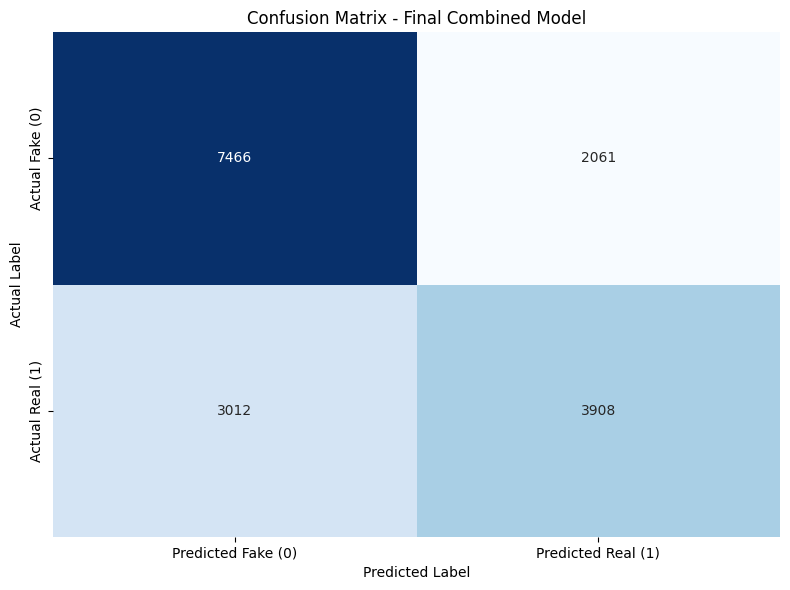


Generating Model Comparison Metrics plot...


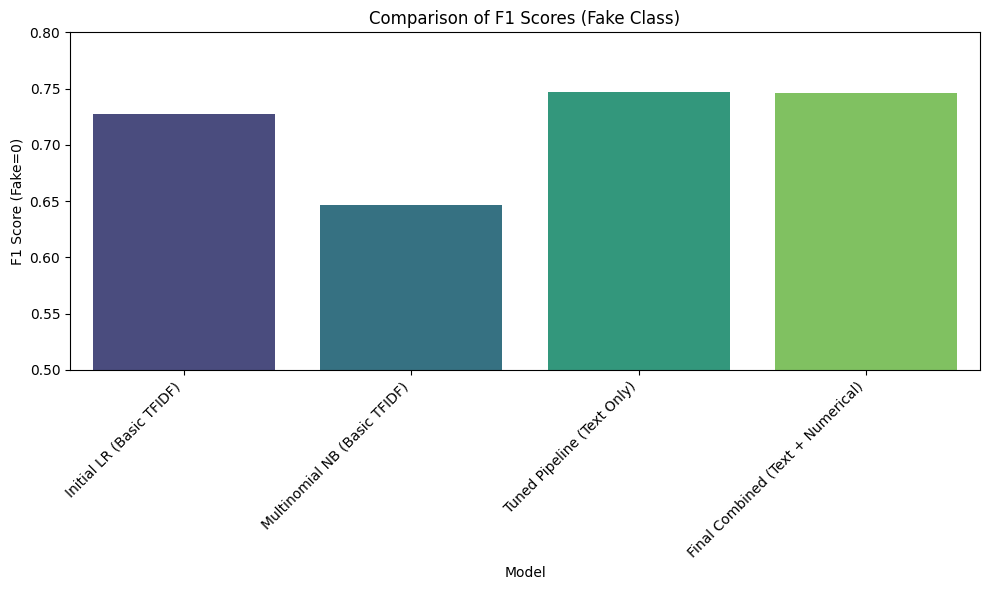

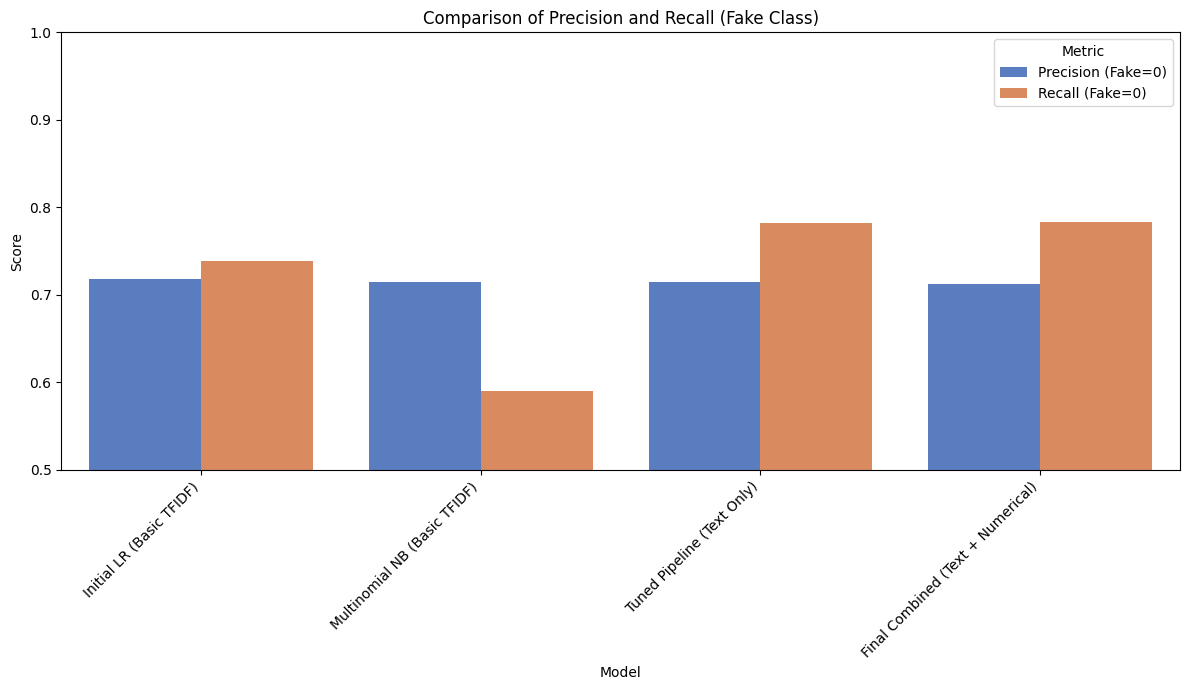


Visualization complete. Plots saved in the 'results_plots/' directory.


In [ ]:
#directory
plot_dir = 'results_plots/'
os.makedirs(plot_dir, exist_ok=True)

#plot the final confusion matrix and save it
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_final_combined, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Fake (0)', 'Predicted Real (1)'],
            yticklabels=['Actual Fake (0)', 'Actual Real (1)'])
plt.title('Confusion Matrix - Final Combined Model')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.tight_layout() 
plt.savefig(os.path.join(plot_dir, 'final_confusion_matrix.png')) 
plt.show() 

#compare main metrics for each model
results_data = {
    'Model': ['Initial LR (Basic TFIDF)', 'Multinomial NB (Basic TFIDF)', 'Tuned Pipeline (Text Only)', 'Final Combined (Text + Numerical)'],
    'F1 Score (Fake=0)': [f1_log_reg, f1_nb, f1_final, f1_final_combined],
    'Precision (Fake=0)': [precision_log_reg, precision_nb, precision_final, precision_final_combined],
    'Recall (Fake=0)': [recall_log_reg, recall_nb, recall_final, recall_final_combined], 
    'Accuracy': [accuracy_log_reg, accuracy_nb, accuracy_final, accuracy_final_combined]
}

df_results = pd.DataFrame(results_data)

#plot F1-Score and save it
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='F1 Score (Fake=0)', data=df_results, hue='Model', palette='viridis', legend=False)
plt.title('Comparison of F1 Scores (Fake Class)')
plt.ylabel('F1 Score (Fake=0)')
plt.ylim(0.5, 0.8) 
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, 'model_f1_comparison.png')) 
plt.show()

#plot preicsion and recall and save it
df_results_melted = df_results.melt(id_vars='Model', value_vars=['Precision (Fake=0)', 'Recall (Fake=0)'], var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 7))
sns.barplot(x='Model', y='Score', hue='Metric', data=df_results_melted, palette='muted')
plt.title('Comparison of Precision and Recall (Fake Class)')
plt.ylabel('Score')
plt.ylim(0.5, 1.0) 
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric')
plt.tight_layout()
plt.savefig(os.path.join(plot_dir, 'model_precision_recall_comparison.png')) 
plt.show()


print("\nVisualization Done!")